In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchvision.transforms import functional as TF, InterpolationMode

In [3]:
from src.transform import Transform, ZRotation
from src.datasets.bop import BOPDataset
from src.datasets.objects import ObjectsDataset
from src.pixelnerf.src import util
from src.pixelnerf.src.data import get_split_dataset
from src.pixelnerf.src.model import make_model
from src.pixelnerf.src.render import NeRFRenderer
from src.pixelnerf.src.util import gen_rays
from src.inerf.lieutils import SO3Exp, SE3Exp

In [103]:
sys.argv = ["-f", "-n", "sn64_vanilla", "--resume"]
args, conf = util.args.parse_args()
device = util.get_cuda(args.gpu_id[0])

EXPERIMENT NAME: sn64_vanilla
* Config file: conf/pixelnerf/exp/sn64_vanilla.conf
* Dataset format: dvr
* Dataset location: data


In [104]:
scene_ds = BOPDataset("data/lm", split="train_single")
obj_ds = ObjectsDataset(scene_ds)

Building index and loading annotations...


In [105]:
nmr_ds = get_split_dataset("dvr", "data/nmr", want_split="test", training=False)

Loading DVR dataset data/nmr stage test 2988 objs type: shapenet


In [106]:
net = make_model(conf["model"]).to(device=device)
net.load_weights(args) ;

Using torchvision resnet34 encoder
Normalizing z? True
Load checkpoints/sn64_vanilla/pixel_nerf_latest


In [107]:
renderer = NeRFRenderer.from_conf(
    conf["renderer"], lindisp=obj_ds.lindisp).to(device=device)
renderer.n_coarse = 64
renderer.n_fine = 128

render_par = renderer.bind_parallel(net, args.gpu_id).eval()

Eval batch size: 100000


# Sanity check

In [108]:
def augment_positions(data):
    params = 0.1 * torch.randn(6)
    T = Transform(SE3Exp(params))
    N = data["poses"].shape[0]
    new_poses = data["poses"]
    for i in range(N):
        new_poses[i, ...] = torch.tensor((T * Transform(new_poses[i, ...])).homogeneous)
    data["poses"] = new_poses
    return data

In [109]:
def augment_rotations(data):
    N = data["poses"].shape[0]
    for i in range(1, N):
        pose = Transform(data["poses"][i])
        mask = data["masks"][i]
        rgb = data["images"][i]
    
        angle = 360 * np.random.rand()
        aug_T = ZRotation(-angle)
        
        pose = pose * aug_T
        mask = TF.rotate(mask.unsqueeze(0), angle, fill=False).squeeze(0)
        rgb = TF.rotate(rgb, angle, interpolation=InterpolationMode.BILINEAR, fill=1)

        data["poses"][i] = torch.tensor(pose.homogeneous)
        data["masks"][i] = mask
        data["images"][i] = rgb
    return data

In [110]:
def plot_pixelnerf(inp, tgt, rend, save=None):
    plt.figure(figsize=(10, 7))

    plt.subplot(1, 3, 1)
    ax = plt.gca()
    ax.axis('off')
    ax.set_title('input')
    plt.imshow(inp)

    plt.subplot(1, 3, 2)
    ax = plt.gca()
    ax.axis('off')
    ax.set_title('target')
    plt.imshow(tgt)

    plt.subplot(1, 3, 3)
    ax = plt.gca()
    ax.axis('off')
    ax.set_title('render')
    plt.imshow(rend)

    if save is not None:
        plt.savefig(save, dpi=300)
    
    plt.show()

In [111]:
def data_to_input(data, idx):
    if data["focal"].ndim == 0:
        focal = torch.tensor(data["focal"][None])
    else:
        focal = data["focal"][idx:idx+1]
    try:
        c = data["c"][idx:idx+1]
    except KeyError:
        c = None
        
    return dict(
        images=data["images"][idx:idx+1],
        focal=focal,
        c=c,
        poses=data["poses"][idx:idx+1],
        bbox=data["bbox"][idx:idx+1],
    )

def data_to_target(data, idx):
    if data["focal"].ndim == 0:
        focal = torch.tensor(data["focal"][None])
    else:
        focal = data["focal"][idx:idx+1]
    try:
        c = data["c"][idx:idx+1]
    except KeyError:
        c = None
        
    return dict(
        poses=data["poses"][idx:idx+1],
        focal=focal,
        c=c,
        W=data["images"][idx].shape[2],
        H=data["images"][idx].shape[1]
    )

In [112]:
def test_random_object(dataset, position_aug=False, rotation_aug=False, verbose=True):
    idx = torch.randint(0, len(dataset), (1,)).item()
    data = dataset[idx]
    if rotation_aug:
        data = augment_rotations(data)
    if position_aug:
        data = augment_positions(data)
    if verbose:
        print("Object", idx, "selected")
    
    n_imgs = data["images"].shape[0]
    inp_idx = torch.randint(0, n_imgs, (1,)).item()
    tgt_idx = torch.randint(0, n_imgs, (1,)).item()
    while inp_idx == tgt_idx:
        tgt_idx = torch.randint(0, n_imgs, (1,)).item()
    if verbose:
        print("Input:", inp_idx, ", target:", tgt_idx)
    
    inputs = data_to_input(data, inp_idx)
    targets = data_to_target(data, tgt_idx)
        
    renders = render_par.render_view(inputs, targets, dataset.z_near, dataset.z_far, args.ray_batch_size)
    rendered_img = renders[0]
    
    input_img = (data["images"][inp_idx] * 0.5 + 0.5).permute(1, 2, 0)
    target_img = (data["images"][tgt_idx] * 0.5 + 0.5).permute(1, 2, 0)
    
    psnr = util.psnr(rendered_img, target_img)
    if verbose:
        print("psnr:", psnr)
    return psnr, input_img, target_img, rendered_img

In [113]:
def test_repeated(dataset, n_times=100, position_aug=False, rotation_aug=False):
    psnrs = []
    for _ in tqdm(range(n_times)):
        psnr, _, _, _ = test_random_object(dataset, position_aug=position_aug, rotation_aug=rotation_aug, verbose=False)
        psnrs.append(psnr)
    psnr = np.mean(np.array(psnrs))
    print("AVG PSNR:", psnr)
    return psnr

Object 1161 selected
Input: 13 , target: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 27.354937361246222


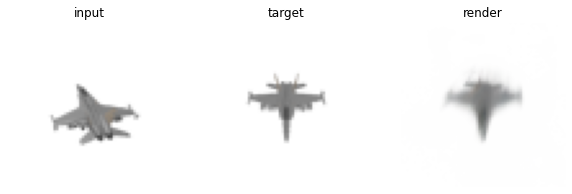

In [116]:
psnr, input_img, target_img, rendered_img = test_random_object(nmr_ds)
plot_pixelnerf(input_img, target_img, rendered_img, save="pretrained.png")

In [117]:
test_repeated(nmr_ds)

100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

AVG PSNR: 28.299641081544365


28.299641081544365

Object 1933 selected
Input: 23 , target: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 11.933770858121493


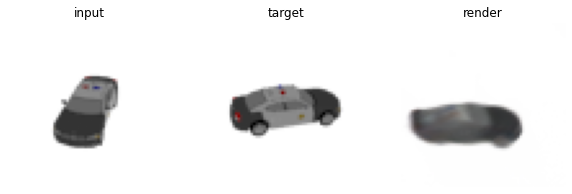

In [118]:
psnr, input_img, target_img, rendered_img = test_random_object(nmr_ds, position_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img)

In [120]:
test_repeated(nmr_ds, position_aug=True)

100%|██████████| 100/100 [02:42<00:00,  1.63s/it]

AVG PSNR: 21.248789585577587


21.248789585577587

Object 2224 selected
Input: 14 , target: 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 17.26940816257804


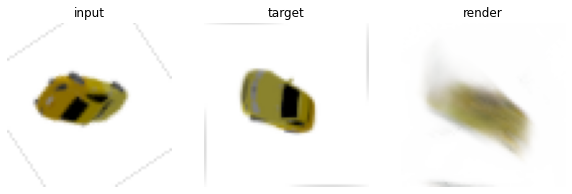

In [121]:
psnr, input_img, target_img, rendered_img = test_random_object(nmr_ds, rotation_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img)

In [122]:
test_repeated(nmr_ds, rotation_aug=True)

100%|██████████| 100/100 [02:44<00:00,  1.64s/it]

AVG PSNR: 19.00449795205537


19.00449795205537

# Transfer test

Object 432 selected
Input: 2 , target: 3
psnr: 11.852825753452052


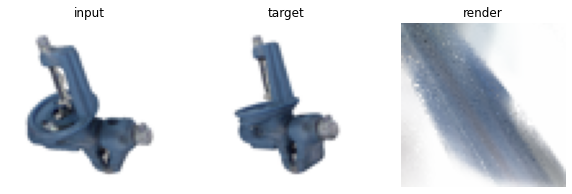

In [47]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds)
plot_pixelnerf(input_img, target_img, rendered_img, save="transfer.png")

In [48]:
test_repeated(obj_ds)

100%|██████████| 100/100 [02:36<00:00,  1.57s/it]

AVG PSNR: 12.12742209687421


12.12742209687421

In [124]:
test_repeated(obj_ds, position_aug=True)

100%|██████████| 100/100 [02:37<00:00,  1.57s/it]

AVG PSNR: 12.757612997750163


12.757612997750163

In [125]:
test_repeated(obj_ds, rotation_aug=True)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

AVG PSNR: 12.286867125056641


12.286867125056641

# Fine-tuned

In [96]:
sys.argv = ["-f", "-n", "sn64_saved", "--resume"]
args, conf = util.args.parse_args()

EXPERIMENT NAME: sn64_saved
* Config file: conf/pixelnerf/exp/sn64_saved.conf
* Dataset format: dvr
* Dataset location: data


In [97]:
net = make_model(conf["model"]).to(device=device)
net.load_weights(args) ;

Using torchvision resnet34 encoder
Normalizing z? True
Load checkpoints/sn64_saved/pixel_nerf_latest


In [98]:
renderer = NeRFRenderer.from_conf(
    conf["renderer"], lindisp=obj_ds.lindisp).to(device=device)
renderer.n_coarse = 64
renderer.n_fine = 128

render_par = renderer.bind_parallel(net, args.gpu_id).eval()

Eval batch size: 100000


Object 3398 selected
Input: 3 , target: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 23.938802132842714


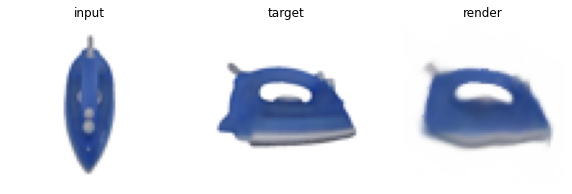

In [69]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds)
plot_pixelnerf(input_img, target_img, rendered_img, save="fine_tuned1.png")

In [54]:
test_repeated(obj_ds)

100%|██████████| 100/100 [02:38<00:00,  1.58s/it]

AVG PSNR: 26.01249943882738


26.01249943882738

Object 1362 selected
Input: 1 , target: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 16.86577088910992


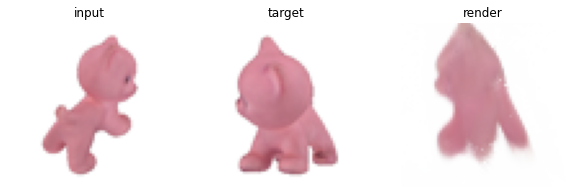

In [67]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds, position_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img, save="fine_tuned2.png")

In [99]:
test_repeated(obj_ds, position_aug=True)

  2%|▏         | 2/100 [00:04<03:34,  2.19s/it]


KeyboardInterrupt: 

In [100]:
test_repeated(obj_ds, rotation_aug=True)

100%|██████████| 100/100 [02:38<00:00,  1.58s/it]

AVG PSNR: 15.851306492909327


15.851306492909327

# Normalize_z = False

In [71]:
sys.argv = ["-f", "-n", "sn64", "--resume"]
args, conf = util.args.parse_args()

EXPERIMENT NAME: sn64
* Config file: conf/pixelnerf/exp/sn64.conf
* Dataset format: dvr
* Dataset location: data


In [72]:
net = make_model(conf["model"]).to(device=device)
net.load_weights(args) ;

Using torchvision resnet34 encoder
Normalizing z? False
Load checkpoints/sn64/pixel_nerf_latest


In [73]:
renderer = NeRFRenderer.from_conf(
    conf["renderer"], lindisp=obj_ds.lindisp).to(device=device)
renderer.n_coarse = 64
renderer.n_fine = 128

render_par = renderer.bind_parallel(net, args.gpu_id).eval()

Eval batch size: 100000


Object 63 selected
Input: 1 , target: 2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 25.869756933903048


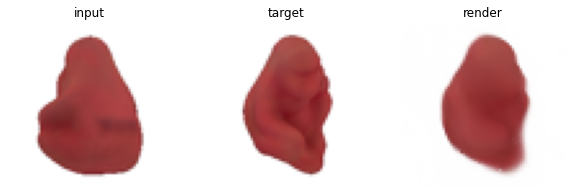

In [78]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds)
plot_pixelnerf(input_img, target_img, rendered_img)

In [79]:
test_repeated(obj_ds)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

AVG PSNR: 26.247577204314503


26.247577204314503

Object 2179 selected
Input: 0 , target: 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


psnr: 25.097253240151037


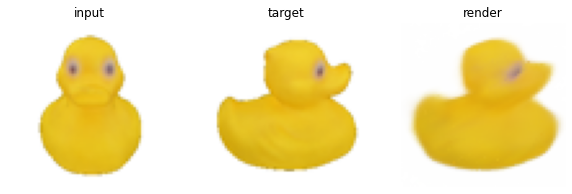

In [82]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds, position_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img, save="fine_tuned3.png")

In [83]:
test_repeated(obj_ds, position_aug=True)

100%|██████████| 100/100 [02:38<00:00,  1.58s/it]

AVG PSNR: 25.799730665005146


25.799730665005146

Object 2352 selected
Input: 1 , target: 4
psnr: 13.775301892856133


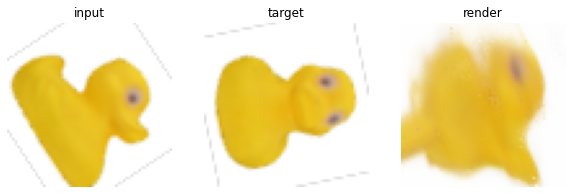

In [91]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds, rotation_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img, save="fine_tuned4.png")

In [92]:
test_repeated(obj_ds, rotation_aug=True)

100%|██████████| 100/100 [02:40<00:00,  1.60s/it]

AVG PSNR: 15.882558383012775


15.882558383012775

# Rotation aug training

In [126]:
sys.argv = ["-f", "-n", "sn64_aug", "--resume"]
args, conf = util.args.parse_args()

EXPERIMENT NAME: sn64_aug
* Config file: conf/pixelnerf/exp/sn64_aug.conf
* Dataset format: dvr
* Dataset location: data


In [127]:
net = make_model(conf["model"]).to(device=device)
net.load_weights(args) ;

Using torchvision resnet34 encoder
Normalizing z? False
Load checkpoints/sn64_aug/pixel_nerf_latest


In [128]:
renderer = NeRFRenderer.from_conf(
    conf["renderer"], lindisp=obj_ds.lindisp).to(device=device)
renderer.n_coarse = 64
renderer.n_fine = 128

render_par = renderer.bind_parallel(net, args.gpu_id).eval()

Eval batch size: 100000


Object 1769 selected
Input: 3 , target: 1
psnr: 11.020111274004822


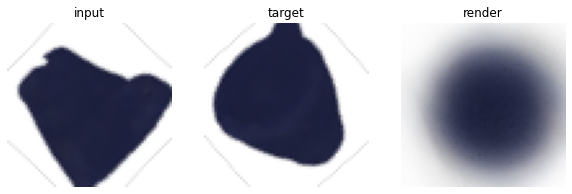

In [151]:
psnr, input_img, target_img, rendered_img = test_random_object(obj_ds, rotation_aug=True)
plot_pixelnerf(input_img, target_img, rendered_img, save="fine_tuned5.png")

In [153]:
test_repeated(obj_ds)

100%|██████████| 100/100 [02:30<00:00,  1.50s/it]

AVG PSNR: 15.476729145138245


15.476729145138245

In [154]:
test_repeated(obj_ds, position_aug=True)

100%|██████████| 100/100 [02:39<00:00,  1.60s/it]

AVG PSNR: 16.34765354095673


16.34765354095673

In [152]:
test_repeated(obj_ds, rotation_aug=True)

100%|██████████| 100/100 [02:37<00:00,  1.58s/it]

AVG PSNR: 16.04450493818502


16.04450493818502